In [16]:
# Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import torch
from torch import nn

In [17]:
# Importing data

data_set = pd.read_csv('cleaned_data.csv')

# Set index column

data_set.set_index('audio file',inplace=True)

data_set.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc2_sma3_stddevNorm,mfcc3_sma3_stddevNorm,...,slopeV0-500_sma3nz_stddevNorm,slopeV500-1500_sma3nz_stddevNorm,spectralFluxV_sma3nz_amean,spectralFluxV_sma3nz_stddevNorm,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,MeanVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,equivalentSoundLevel_dBp,status
audio file,,,,,,,,,,,,,,,,,,,,,
adrso024,22.836117,7.935173,150.88577,0.549328,0.831140,5.262211,0.508837,1.326787,1.659299,2.070628,...,0.882923,-0.567350,0.550346,1.225269,0.163655,1.585821,0.733627,0.100488,-26.253954,ad
adrso025,25.950464,11.863705,177.42262,0.398178,1.058877,5.992081,0.200731,1.719531,1.825399,1.010119,...,0.633215,-0.695343,0.327789,1.311078,0.069983,0.774302,0.213387,0.221147,-32.320164,ad
adrso027,19.768696,11.135247,167.47725,0.460953,0.707600,5.662509,0.207583,1.357751,0.648870,1.462580,...,12.945907,-0.940123,0.283992,1.236332,0.134296,0.727537,0.099811,0.112874,-34.366104,ad
adrso028,22.070637,13.376965,147.31458,0.399583,1.533441,8.396350,0.202821,2.647187,3.380660,1.010571,...,1.270049,-0.652363,0.235273,2.537468,0.118246,0.482315,0.174490,0.069385,-28.948114,ad
adrso031,29.309093,22.327736,136.47410,0.358402,0.733677,9.875219,0.149938,1.618128,0.852065,1.973424,...,1.526530,-0.909497,0.223593,1.312532,0.083634,0.689995,0.171469,0.208814,-35.530070,ad


In [18]:
df = data_set

####  NN modelling

In [19]:
df_scale = scale(df.iloc[:,:-1])
X = df_scale[:,:-1]
y = df['status']

y[y == 'ad'] = 1
y[y == 'cn'] = 0
y = np.array(y,dtype=np.float16)

C:\Users\Nadun\AppData\Local\Temp\ipykernel_13204\46129917.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'ad'] = 1
C:\Users\Nadun\AppData\Local\Temp\ipykernel_13204\46129917.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'cn'] = 0


In [20]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [22]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle = True,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=153)

In [23]:

device = "cpu"

#### ReLu with two layers

In [24]:
K = np.arange(2,31,1)
epochs = 100
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for k in K:
    class NN_model(nn.Module):
        def __init__(self):
            super().__init__()
            self.layer_1 = nn.Linear(in_features=36, out_features=k) 
            self.layer_2 = nn.Linear(in_features=k, out_features=1)
            self.relu = nn.ReLU()
        #self.relu = nn.Sigmoid() 
    
        def forward(self, x):

            return self.layer_2(self.relu(self.layer_1(x)))
    

    neural_network_mod = NN_model().to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(params=neural_network_mod.parameters(), 
                            lr=0.1)
    

    for epoch in range(epochs):

        neural_network_mod.train()


        y_logits = neural_network_mod(X_train).squeeze()
        
        y_pred = torch.round(torch.sigmoid(y_logits)) 


        train_loss = loss_function(y_logits, 
                       y_train) 
        

        train_accuracy = accuracy_score(y_train.detach().numpy(), y_pred.detach().numpy()) * 100



        optimizer.zero_grad()


        train_loss.backward()


        optimizer.step()


        neural_network_mod.eval()

        with torch.inference_mode():

            test_logits = neural_network_mod(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_function(test_logits,
                                y_test)
            test_accuracy = accuracy_score(y_test.detach().numpy(), test_pred.detach().numpy()) * 100
            
        
        
        if epoch % 10 ==0:
            print(f"K = {k},Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")
        
    print('#'*88)
    
    



K = 2,Epoch: 0 | Loss: 0.77337, Accuracy: 48.68% | Test loss: 0.75191, Test acc: 47.92%
K = 2,Epoch: 10 | Loss: 0.70238, Accuracy: 48.68% | Test loss: 0.70521, Test acc: 47.92%
K = 2,Epoch: 20 | Loss: 0.66767, Accuracy: 48.68% | Test loss: 0.67894, Test acc: 47.92%
K = 2,Epoch: 30 | Loss: 0.64910, Accuracy: 48.68% | Test loss: 0.66293, Test acc: 47.92%
K = 2,Epoch: 40 | Loss: 0.63523, Accuracy: 68.78% | Test loss: 0.65192, Test acc: 68.75%
K = 2,Epoch: 50 | Loss: 0.62474, Accuracy: 71.96% | Test loss: 0.64387, Test acc: 64.58%
K = 2,Epoch: 60 | Loss: 0.61636, Accuracy: 71.43% | Test loss: 0.63769, Test acc: 64.58%
K = 2,Epoch: 70 | Loss: 0.60937, Accuracy: 70.37% | Test loss: 0.63321, Test acc: 66.67%
K = 2,Epoch: 80 | Loss: 0.60344, Accuracy: 69.84% | Test loss: 0.62975, Test acc: 66.67%
K = 2,Epoch: 90 | Loss: 0.59837, Accuracy: 70.90% | Test loss: 0.62692, Test acc: 66.67%
########################################################################################
K = 3,Epoch: 0 | Loss:

########################################################################################
K = 11,Epoch: 0 | Loss: 0.72046, Accuracy: 49.74% | Test loss: 0.69926, Test acc: 50.00%
K = 11,Epoch: 10 | Loss: 0.66623, Accuracy: 62.43% | Test loss: 0.66800, Test acc: 64.58%
K = 11,Epoch: 20 | Loss: 0.63485, Accuracy: 67.20% | Test loss: 0.64928, Test acc: 70.83%
K = 11,Epoch: 30 | Loss: 0.61141, Accuracy: 68.78% | Test loss: 0.63823, Test acc: 70.83%
K = 11,Epoch: 40 | Loss: 0.59179, Accuracy: 69.84% | Test loss: 0.63106, Test acc: 68.75%
K = 11,Epoch: 50 | Loss: 0.57585, Accuracy: 69.84% | Test loss: 0.62832, Test acc: 68.75%
K = 11,Epoch: 60 | Loss: 0.56228, Accuracy: 70.37% | Test loss: 0.62780, Test acc: 68.75%
K = 11,Epoch: 70 | Loss: 0.55024, Accuracy: 69.84% | Test loss: 0.63031, Test acc: 68.75%
K = 11,Epoch: 80 | Loss: 0.53945, Accuracy: 70.90% | Test loss: 0.63200, Test acc: 68.75%
K = 11,Epoch: 90 | Loss: 0.52986, Accuracy: 69.84% | Test loss: 0.63238, Test acc: 68.75%
############

K = 20,Epoch: 40 | Loss: 0.59679, Accuracy: 69.84% | Test loss: 0.65841, Test acc: 68.75%
K = 20,Epoch: 50 | Loss: 0.57714, Accuracy: 70.90% | Test loss: 0.64774, Test acc: 68.75%
K = 20,Epoch: 60 | Loss: 0.56001, Accuracy: 71.43% | Test loss: 0.63978, Test acc: 68.75%
K = 20,Epoch: 70 | Loss: 0.54600, Accuracy: 71.43% | Test loss: 0.63504, Test acc: 70.83%
K = 20,Epoch: 80 | Loss: 0.53426, Accuracy: 71.96% | Test loss: 0.63302, Test acc: 70.83%
K = 20,Epoch: 90 | Loss: 0.52404, Accuracy: 70.90% | Test loss: 0.63203, Test acc: 70.83%
########################################################################################
K = 21,Epoch: 0 | Loss: 0.68383, Accuracy: 53.97% | Test loss: 0.69006, Test acc: 58.33%
K = 21,Epoch: 10 | Loss: 0.64955, Accuracy: 61.38% | Test loss: 0.65998, Test acc: 64.58%
K = 21,Epoch: 20 | Loss: 0.62440, Accuracy: 66.67% | Test loss: 0.64317, Test acc: 60.42%
K = 21,Epoch: 30 | Loss: 0.60472, Accuracy: 68.25% | Test loss: 0.63260, Test acc: 60.42%
K = 21,Epoch

########################################################################################
K = 30,Epoch: 0 | Loss: 0.69234, Accuracy: 50.79% | Test loss: 0.67791, Test acc: 56.25%
K = 30,Epoch: 10 | Loss: 0.65678, Accuracy: 65.08% | Test loss: 0.65279, Test acc: 60.42%
K = 30,Epoch: 20 | Loss: 0.63035, Accuracy: 67.72% | Test loss: 0.63414, Test acc: 60.42%
K = 30,Epoch: 30 | Loss: 0.60845, Accuracy: 67.72% | Test loss: 0.62046, Test acc: 58.33%
K = 30,Epoch: 40 | Loss: 0.58938, Accuracy: 68.78% | Test loss: 0.61194, Test acc: 62.50%
K = 30,Epoch: 50 | Loss: 0.57318, Accuracy: 69.84% | Test loss: 0.60756, Test acc: 62.50%
K = 30,Epoch: 60 | Loss: 0.55903, Accuracy: 70.37% | Test loss: 0.60640, Test acc: 64.58%
K = 30,Epoch: 70 | Loss: 0.54614, Accuracy: 70.90% | Test loss: 0.60687, Test acc: 64.58%
K = 30,Epoch: 80 | Loss: 0.53400, Accuracy: 70.37% | Test loss: 0.60809, Test acc: 68.75%
K = 30,Epoch: 90 | Loss: 0.52313, Accuracy: 71.96% | Test loss: 0.60967, Test acc: 68.75%
############

#### Sigmoid with 2 layers

In [25]:
K = np.arange(2,31,1)
epochs = 100
torch.manual_seed(42)



for k in K:
    class NN_model(nn.Module):
        def __init__(self):
            super().__init__()
            self.layer_1 = nn.Linear(in_features=36, out_features=k) 
            self.layer_2 = nn.Linear(in_features=k, out_features=1)
            #self.relu = nn.ReLU()
            self.relu = nn.Sigmoid() 
    
        def forward(self, x):

            return self.layer_2(self.relu(self.layer_1(x)))
    

    neural_network_mod = NN_model().to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(params=neural_network_mod.parameters(), 
                            lr=0.1)
    

    for epoch in range(epochs):

        neural_network_mod.train()


        y_logits = neural_network_mod(X_train).squeeze()
        
        y_pred = torch.round(torch.sigmoid(y_logits)) 


        train_loss = loss_function(y_logits, 
                       y_train) 
        

        train_accuracy = accuracy_score(y_train.detach().numpy(), y_pred.detach().numpy()) * 100



        optimizer.zero_grad()


        train_loss.backward()


        optimizer.step()


        neural_network_mod.eval()

        with torch.inference_mode():

            test_logits = neural_network_mod(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_function(test_logits,
                                y_test)
            test_accuracy = accuracy_score(y_test.detach().numpy(), test_pred.detach().numpy()) * 100
            
        
        if epoch % 10 ==0:
            print(f"K = {k},Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")
        
    print('#'*89)
    
    



K = 2,Epoch: 0 | Loss: 0.84800, Accuracy: 48.68% | Test loss: 0.85465, Test acc: 47.92%
K = 2,Epoch: 10 | Loss: 0.76157, Accuracy: 48.68% | Test loss: 0.76907, Test acc: 47.92%
K = 2,Epoch: 20 | Loss: 0.71819, Accuracy: 48.68% | Test loss: 0.72492, Test acc: 47.92%
K = 2,Epoch: 30 | Loss: 0.69657, Accuracy: 48.68% | Test loss: 0.70220, Test acc: 47.92%
K = 2,Epoch: 40 | Loss: 0.68533, Accuracy: 50.26% | Test loss: 0.69003, Test acc: 47.92%
K = 2,Epoch: 50 | Loss: 0.67889, Accuracy: 53.44% | Test loss: 0.68294, Test acc: 50.00%
K = 2,Epoch: 60 | Loss: 0.67461, Accuracy: 57.67% | Test loss: 0.67832, Test acc: 50.00%
K = 2,Epoch: 70 | Loss: 0.67127, Accuracy: 61.90% | Test loss: 0.67489, Test acc: 58.33%
K = 2,Epoch: 80 | Loss: 0.66832, Accuracy: 66.67% | Test loss: 0.67206, Test acc: 64.58%
K = 2,Epoch: 90 | Loss: 0.66550, Accuracy: 65.08% | Test loss: 0.66953, Test acc: 64.58%
#########################################################################################
K = 3,Epoch: 0 | Loss

K = 11,Epoch: 30 | Loss: 0.67609, Accuracy: 65.61% | Test loss: 0.67753, Test acc: 56.25%
K = 11,Epoch: 40 | Loss: 0.67094, Accuracy: 66.14% | Test loss: 0.67240, Test acc: 58.33%
K = 11,Epoch: 50 | Loss: 0.66579, Accuracy: 65.61% | Test loss: 0.66741, Test acc: 60.42%
K = 11,Epoch: 60 | Loss: 0.66057, Accuracy: 66.14% | Test loss: 0.66247, Test acc: 58.33%
K = 11,Epoch: 70 | Loss: 0.65531, Accuracy: 68.25% | Test loss: 0.65759, Test acc: 58.33%
K = 11,Epoch: 80 | Loss: 0.65004, Accuracy: 68.25% | Test loss: 0.65280, Test acc: 60.42%
K = 11,Epoch: 90 | Loss: 0.64481, Accuracy: 68.25% | Test loss: 0.64817, Test acc: 60.42%
#########################################################################################
K = 12,Epoch: 0 | Loss: 0.68918, Accuracy: 51.32% | Test loss: 0.69047, Test acc: 52.08%
K = 12,Epoch: 10 | Loss: 0.68337, Accuracy: 55.56% | Test loss: 0.68502, Test acc: 58.33%
K = 12,Epoch: 20 | Loss: 0.67778, Accuracy: 60.32% | Test loss: 0.67977, Test acc: 64.58%
K = 12,Epoc

K = 20,Epoch: 30 | Loss: 0.68130, Accuracy: 56.08% | Test loss: 0.68733, Test acc: 56.25%
K = 20,Epoch: 40 | Loss: 0.67621, Accuracy: 59.79% | Test loss: 0.68234, Test acc: 62.50%
K = 20,Epoch: 50 | Loss: 0.67102, Accuracy: 63.49% | Test loss: 0.67732, Test acc: 64.58%
K = 20,Epoch: 60 | Loss: 0.66567, Accuracy: 64.02% | Test loss: 0.67223, Test acc: 66.67%
K = 20,Epoch: 70 | Loss: 0.66018, Accuracy: 66.14% | Test loss: 0.66707, Test acc: 68.75%
K = 20,Epoch: 80 | Loss: 0.65457, Accuracy: 66.67% | Test loss: 0.66189, Test acc: 70.83%
K = 20,Epoch: 90 | Loss: 0.64891, Accuracy: 66.67% | Test loss: 0.65674, Test acc: 64.58%
#########################################################################################
K = 21,Epoch: 0 | Loss: 0.70113, Accuracy: 51.32% | Test loss: 0.70263, Test acc: 52.08%
K = 21,Epoch: 10 | Loss: 0.67971, Accuracy: 54.50% | Test loss: 0.68757, Test acc: 56.25%
K = 21,Epoch: 20 | Loss: 0.67203, Accuracy: 60.85% | Test loss: 0.68097, Test acc: 60.42%
K = 21,Epoc

#########################################################################################
K = 29,Epoch: 0 | Loss: 0.71600, Accuracy: 48.68% | Test loss: 0.72161, Test acc: 41.67%
K = 29,Epoch: 10 | Loss: 0.69461, Accuracy: 49.74% | Test loss: 0.70337, Test acc: 45.83%
K = 29,Epoch: 20 | Loss: 0.68746, Accuracy: 55.56% | Test loss: 0.69522, Test acc: 54.17%
K = 29,Epoch: 30 | Loss: 0.68083, Accuracy: 58.20% | Test loss: 0.68783, Test acc: 54.17%
K = 29,Epoch: 40 | Loss: 0.67436, Accuracy: 58.20% | Test loss: 0.68074, Test acc: 56.25%
K = 29,Epoch: 50 | Loss: 0.66789, Accuracy: 63.49% | Test loss: 0.67379, Test acc: 60.42%
K = 29,Epoch: 60 | Loss: 0.66138, Accuracy: 66.14% | Test loss: 0.66692, Test acc: 60.42%
K = 29,Epoch: 70 | Loss: 0.65482, Accuracy: 65.61% | Test loss: 0.66013, Test acc: 60.42%
K = 29,Epoch: 80 | Loss: 0.64826, Accuracy: 67.20% | Test loss: 0.65349, Test acc: 60.42%
K = 29,Epoch: 90 | Loss: 0.64179, Accuracy: 66.67% | Test loss: 0.64710, Test acc: 60.42%
###########

#### ReLu with 3 layers 

In [26]:
K = np.arange(2,31,1)
epochs = 100
torch.manual_seed(42)


for k in K:
    class NN_model(nn.Module):
        def __init__(self):
            super().__init__()
            self.layer_1 = nn.Linear(in_features=36, out_features=k) 
            self.layer_2 = nn.Linear(in_features=k, out_features=k)
            self.layer_3 = nn.Linear(in_features=k, out_features=1)
            self.relu = nn.ReLU()
            #self.relu = nn.Sigmoid() 
    
        def forward(self, x):

            return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    

    neural_network_mod = NN_model().to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(params=neural_network_mod.parameters(), 
                            lr=0.1)
    

    for epoch in range(epochs):

        neural_network_mod.train()


        y_logits = neural_network_mod(X_train).squeeze()
        
        y_pred = torch.round(torch.sigmoid(y_logits)) 


        train_loss = loss_function(y_logits, 
                       y_train) 
        

        train_accuracy = accuracy_score(y_train.detach().numpy(), y_pred.detach().numpy()) * 100



        optimizer.zero_grad()


        train_loss.backward()


        optimizer.step()


        neural_network_mod.eval()

        with torch.inference_mode():

            test_logits = neural_network_mod(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_function(test_logits,
                                y_test)
            test_accuracy = accuracy_score(y_test.detach().numpy(), test_pred.detach().numpy()) * 100
            
        
        if epoch % 10 ==0:
            print(f"K = {k},Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")
        
    print('#'*89)
    
    



K = 2,Epoch: 0 | Loss: 0.70607, Accuracy: 47.09% | Test loss: 0.71035, Test acc: 52.08%
K = 2,Epoch: 10 | Loss: 0.69220, Accuracy: 52.91% | Test loss: 0.69968, Test acc: 56.25%
K = 2,Epoch: 20 | Loss: 0.68189, Accuracy: 62.96% | Test loss: 0.69237, Test acc: 58.33%
K = 2,Epoch: 30 | Loss: 0.67757, Accuracy: 60.85% | Test loss: 0.68814, Test acc: 56.25%
K = 2,Epoch: 40 | Loss: 0.67200, Accuracy: 61.38% | Test loss: 0.68155, Test acc: 64.58%
K = 2,Epoch: 50 | Loss: 0.66674, Accuracy: 65.61% | Test loss: 0.67853, Test acc: 64.58%
K = 2,Epoch: 60 | Loss: 0.66225, Accuracy: 66.14% | Test loss: 0.67646, Test acc: 62.50%
K = 2,Epoch: 70 | Loss: 0.65821, Accuracy: 67.20% | Test loss: 0.67454, Test acc: 62.50%
K = 2,Epoch: 80 | Loss: 0.65373, Accuracy: 68.25% | Test loss: 0.67215, Test acc: 62.50%
K = 2,Epoch: 90 | Loss: 0.64961, Accuracy: 68.25% | Test loss: 0.66938, Test acc: 62.50%
#########################################################################################
K = 3,Epoch: 0 | Loss

K = 10,Epoch: 90 | Loss: 0.66030, Accuracy: 60.85% | Test loss: 0.67646, Test acc: 56.25%
#########################################################################################
K = 11,Epoch: 0 | Loss: 0.70670, Accuracy: 48.68% | Test loss: 0.70323, Test acc: 47.92%
K = 11,Epoch: 10 | Loss: 0.69708, Accuracy: 49.21% | Test loss: 0.69462, Test acc: 47.92%
K = 11,Epoch: 20 | Loss: 0.69080, Accuracy: 50.79% | Test loss: 0.68873, Test acc: 47.92%
K = 11,Epoch: 30 | Loss: 0.68565, Accuracy: 51.85% | Test loss: 0.68388, Test acc: 47.92%
K = 11,Epoch: 40 | Loss: 0.68063, Accuracy: 59.26% | Test loss: 0.67906, Test acc: 56.25%
K = 11,Epoch: 50 | Loss: 0.67507, Accuracy: 62.96% | Test loss: 0.67344, Test acc: 62.50%
K = 11,Epoch: 60 | Loss: 0.66794, Accuracy: 66.67% | Test loss: 0.66619, Test acc: 66.67%
K = 11,Epoch: 70 | Loss: 0.65804, Accuracy: 68.25% | Test loss: 0.65666, Test acc: 70.83%
K = 11,Epoch: 80 | Loss: 0.64580, Accuracy: 69.31% | Test loss: 0.64621, Test acc: 72.92%
K = 11,Epoc

K = 19,Epoch: 20 | Loss: 0.67133, Accuracy: 62.43% | Test loss: 0.69426, Test acc: 58.33%
K = 19,Epoch: 30 | Loss: 0.66335, Accuracy: 62.96% | Test loss: 0.69087, Test acc: 56.25%
K = 19,Epoch: 40 | Loss: 0.65448, Accuracy: 64.02% | Test loss: 0.68736, Test acc: 56.25%
K = 19,Epoch: 50 | Loss: 0.64461, Accuracy: 65.08% | Test loss: 0.68412, Test acc: 58.33%
K = 19,Epoch: 60 | Loss: 0.63401, Accuracy: 67.72% | Test loss: 0.68147, Test acc: 60.42%
K = 19,Epoch: 70 | Loss: 0.62268, Accuracy: 68.78% | Test loss: 0.67939, Test acc: 60.42%
K = 19,Epoch: 80 | Loss: 0.61101, Accuracy: 69.84% | Test loss: 0.67782, Test acc: 62.50%
K = 19,Epoch: 90 | Loss: 0.59929, Accuracy: 70.37% | Test loss: 0.67751, Test acc: 64.58%
#########################################################################################
K = 20,Epoch: 0 | Loss: 0.69308, Accuracy: 49.21% | Test loss: 0.68893, Test acc: 52.08%
K = 20,Epoch: 10 | Loss: 0.68430, Accuracy: 53.97% | Test loss: 0.68185, Test acc: 52.08%
K = 20,Epoc

K = 28,Epoch: 40 | Loss: 0.66132, Accuracy: 66.67% | Test loss: 0.66723, Test acc: 62.50%
K = 28,Epoch: 50 | Loss: 0.65073, Accuracy: 70.37% | Test loss: 0.66005, Test acc: 64.58%
K = 28,Epoch: 60 | Loss: 0.63810, Accuracy: 69.84% | Test loss: 0.65249, Test acc: 68.75%
K = 28,Epoch: 70 | Loss: 0.62407, Accuracy: 68.25% | Test loss: 0.64505, Test acc: 64.58%
K = 28,Epoch: 80 | Loss: 0.60936, Accuracy: 69.31% | Test loss: 0.63914, Test acc: 64.58%
K = 28,Epoch: 90 | Loss: 0.59477, Accuracy: 69.31% | Test loss: 0.63577, Test acc: 64.58%
#########################################################################################
K = 29,Epoch: 0 | Loss: 0.70616, Accuracy: 48.68% | Test loss: 0.70244, Test acc: 47.92%
K = 29,Epoch: 10 | Loss: 0.68569, Accuracy: 60.85% | Test loss: 0.69276, Test acc: 47.92%
K = 29,Epoch: 20 | Loss: 0.67305, Accuracy: 62.96% | Test loss: 0.68763, Test acc: 58.33%
K = 29,Epoch: 30 | Loss: 0.66204, Accuracy: 62.96% | Test loss: 0.68339, Test acc: 60.42%
K = 29,Epoc

#### Sigmoid function with 3 layers - it looks like it needs more epochs

In [27]:
K = np.arange(2,31,1)
epochs = 100
torch.manual_seed(42)



for k in K:
    class NN_model(nn.Module):
        def __init__(self):
            super().__init__()
            self.layer_1 = nn.Linear(in_features=36, out_features=k) 
            self.layer_2 = nn.Linear(in_features=k, out_features=k)
            self.layer_3 = nn.Linear(in_features=k, out_features=1)
            #self.relu = nn.ReLU()
            self.relu = nn.Sigmoid() 
    
        def forward(self, x):

            return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    

    neural_network_mod = NN_model().to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(params=neural_network_mod.parameters(), 
                            lr=0.1)
    

    for epoch in range(epochs):

        neural_network_mod.train()


        y_logits = neural_network_mod(X_train).squeeze()
        
        y_pred = torch.round(torch.sigmoid(y_logits)) 


        train_loss = loss_function(y_logits, 
                       y_train) 
        

        train_accuracy = accuracy_score(y_train.detach().numpy(), y_pred.detach().numpy()) * 100



        optimizer.zero_grad()


        train_loss.backward()


        optimizer.step()


        neural_network_mod.eval()

        with torch.inference_mode():

            test_logits = neural_network_mod(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_function(test_logits,
                                y_test)
            test_accuracy = accuracy_score(y_test.detach().numpy(), test_pred.detach().numpy()) * 100
            
        if epoch % 10 ==0:
            print(f"K = {k},Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")
        
    print('#'*88)



K = 2,Epoch: 0 | Loss: 0.69613, Accuracy: 48.68% | Test loss: 0.69661, Test acc: 47.92%
K = 2,Epoch: 10 | Loss: 0.69486, Accuracy: 46.56% | Test loss: 0.69519, Test acc: 41.67%
K = 2,Epoch: 20 | Loss: 0.69422, Accuracy: 45.50% | Test loss: 0.69442, Test acc: 43.75%
K = 2,Epoch: 30 | Loss: 0.69386, Accuracy: 48.68% | Test loss: 0.69397, Test acc: 52.08%
K = 2,Epoch: 40 | Loss: 0.69363, Accuracy: 50.26% | Test loss: 0.69368, Test acc: 52.08%
K = 2,Epoch: 50 | Loss: 0.69346, Accuracy: 49.74% | Test loss: 0.69347, Test acc: 52.08%
K = 2,Epoch: 60 | Loss: 0.69331, Accuracy: 49.74% | Test loss: 0.69329, Test acc: 52.08%
K = 2,Epoch: 70 | Loss: 0.69318, Accuracy: 50.79% | Test loss: 0.69314, Test acc: 52.08%
K = 2,Epoch: 80 | Loss: 0.69305, Accuracy: 50.79% | Test loss: 0.69300, Test acc: 52.08%
K = 2,Epoch: 90 | Loss: 0.69293, Accuracy: 50.79% | Test loss: 0.69287, Test acc: 52.08%
########################################################################################
K = 3,Epoch: 0 | Loss:

K = 11,Epoch: 10 | Loss: 0.69590, Accuracy: 48.68% | Test loss: 0.69554, Test acc: 47.92%
K = 11,Epoch: 20 | Loss: 0.69314, Accuracy: 49.21% | Test loss: 0.69254, Test acc: 56.25%
K = 11,Epoch: 30 | Loss: 0.69274, Accuracy: 51.32% | Test loss: 0.69194, Test acc: 52.08%
K = 11,Epoch: 40 | Loss: 0.69263, Accuracy: 51.32% | Test loss: 0.69174, Test acc: 52.08%
K = 11,Epoch: 50 | Loss: 0.69256, Accuracy: 51.32% | Test loss: 0.69163, Test acc: 52.08%
K = 11,Epoch: 60 | Loss: 0.69249, Accuracy: 51.32% | Test loss: 0.69155, Test acc: 52.08%
K = 11,Epoch: 70 | Loss: 0.69243, Accuracy: 51.32% | Test loss: 0.69147, Test acc: 52.08%
K = 11,Epoch: 80 | Loss: 0.69236, Accuracy: 51.32% | Test loss: 0.69139, Test acc: 52.08%
K = 11,Epoch: 90 | Loss: 0.69229, Accuracy: 51.32% | Test loss: 0.69131, Test acc: 52.08%
########################################################################################
K = 12,Epoch: 0 | Loss: 0.69837, Accuracy: 48.68% | Test loss: 0.69932, Test acc: 47.92%
K = 12,Epoch

K = 19,Epoch: 50 | Loss: 0.69121, Accuracy: 51.32% | Test loss: 0.69167, Test acc: 52.08%
K = 19,Epoch: 60 | Loss: 0.69105, Accuracy: 51.32% | Test loss: 0.69152, Test acc: 52.08%
K = 19,Epoch: 70 | Loss: 0.69087, Accuracy: 51.32% | Test loss: 0.69136, Test acc: 52.08%
K = 19,Epoch: 80 | Loss: 0.69070, Accuracy: 51.32% | Test loss: 0.69120, Test acc: 52.08%
K = 19,Epoch: 90 | Loss: 0.69052, Accuracy: 51.32% | Test loss: 0.69104, Test acc: 52.08%
########################################################################################
K = 20,Epoch: 0 | Loss: 0.69366, Accuracy: 48.15% | Test loss: 0.69302, Test acc: 52.08%
K = 20,Epoch: 10 | Loss: 0.69270, Accuracy: 49.21% | Test loss: 0.69179, Test acc: 52.08%
K = 20,Epoch: 20 | Loss: 0.69243, Accuracy: 51.32% | Test loss: 0.69141, Test acc: 52.08%
K = 20,Epoch: 30 | Loss: 0.69219, Accuracy: 51.32% | Test loss: 0.69111, Test acc: 52.08%
K = 20,Epoch: 40 | Loss: 0.69194, Accuracy: 51.32% | Test loss: 0.69083, Test acc: 52.08%
K = 20,Epoch

K = 28,Epoch: 50 | Loss: 0.69126, Accuracy: 51.32% | Test loss: 0.68998, Test acc: 52.08%
K = 28,Epoch: 60 | Loss: 0.69108, Accuracy: 51.32% | Test loss: 0.68979, Test acc: 52.08%
K = 28,Epoch: 70 | Loss: 0.69090, Accuracy: 51.32% | Test loss: 0.68960, Test acc: 52.08%
K = 28,Epoch: 80 | Loss: 0.69071, Accuracy: 51.32% | Test loss: 0.68940, Test acc: 52.08%
K = 28,Epoch: 90 | Loss: 0.69052, Accuracy: 51.32% | Test loss: 0.68920, Test acc: 52.08%
########################################################################################
K = 29,Epoch: 0 | Loss: 0.71383, Accuracy: 48.68% | Test loss: 0.70737, Test acc: 47.92%
K = 29,Epoch: 10 | Loss: 0.69227, Accuracy: 51.32% | Test loss: 0.69203, Test acc: 52.08%
K = 29,Epoch: 20 | Loss: 0.69201, Accuracy: 51.32% | Test loss: 0.69166, Test acc: 52.08%
K = 29,Epoch: 30 | Loss: 0.69187, Accuracy: 51.32% | Test loss: 0.69152, Test acc: 52.08%
K = 29,Epoch: 40 | Loss: 0.69173, Accuracy: 51.32% | Test loss: 0.69140, Test acc: 52.08%
K = 29,Epoch

In [34]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle = True,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=100)

In [40]:

epochs = 70
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


class NN_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=36, out_features=9) 
        self.layer_2 = nn.Linear(in_features=9, out_features=1)
        self.relu = nn.ReLU()

    
    def forward(self, x):

        return self.layer_2(self.relu(self.layer_1(x)))
    

neural_network_mod = NN_model().to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=neural_network_mod.parameters(), 
                            lr=0.1)
    

for epoch in range(epochs):

    neural_network_mod.train()


    y_logits = neural_network_mod(X_train).squeeze()
        
    y_pred = torch.round(torch.sigmoid(y_logits)) 


    train_loss = loss_function(y_logits, 
                       y_train) 
        

    train_accuracy = accuracy_score(y_train.detach().numpy(), y_pred.detach().numpy()) * 100



    optimizer.zero_grad()


    train_loss.backward()


    optimizer.step()


    neural_network_mod.eval()

    with torch.inference_mode():

        test_logits = neural_network_mod(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_function(test_logits,
                                y_test)
        test_accuracy = accuracy_score(y_test.detach().numpy(), test_pred.detach().numpy()) * 100
        test_precision = precision_score(y_test.detach().numpy(), test_pred.detach().numpy(),average="binary", pos_label=1)*100
        test_recall = recall_score(y_test.detach().numpy(), test_pred.detach().numpy(),average="binary", pos_label=1) * 100
            
        
        

print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_accuracy:.2f}%, Test precision: {test_precision:.2f}%, Test recall: {test_recall:.2f}%")


Test loss: 0.64246, Test accuracy: 68.75%, Test precision: 69.23%, Test recall: 72.00%


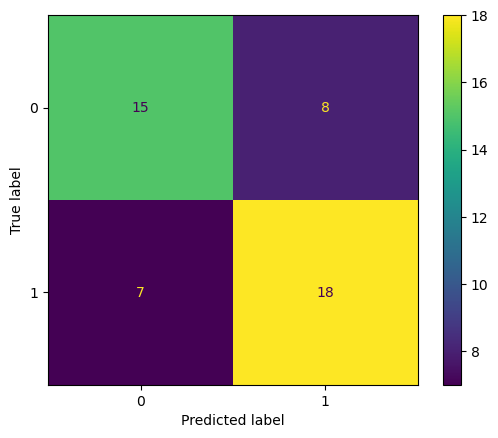

In [41]:
cm_new = confusion_matrix(y_test.detach().numpy(), test_pred.detach().numpy())

ConfusionMatrixDisplay(confusion_matrix=cm_new).plot();